<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/FinalizedPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Act II: The Commercial Compromise - Panel A Only
Kinetics figure only. No external CSV loads.

Loading dialysis DOC data...
  Loaded 3 time points
  Total carbon removed: 0.699 mg

Fitting dialysis kinetics...
  M0 = 0.996 ± 0.337 mg
  k = 0.031 ± 0.017 h^-1
  t1/2 = 22.4 hours


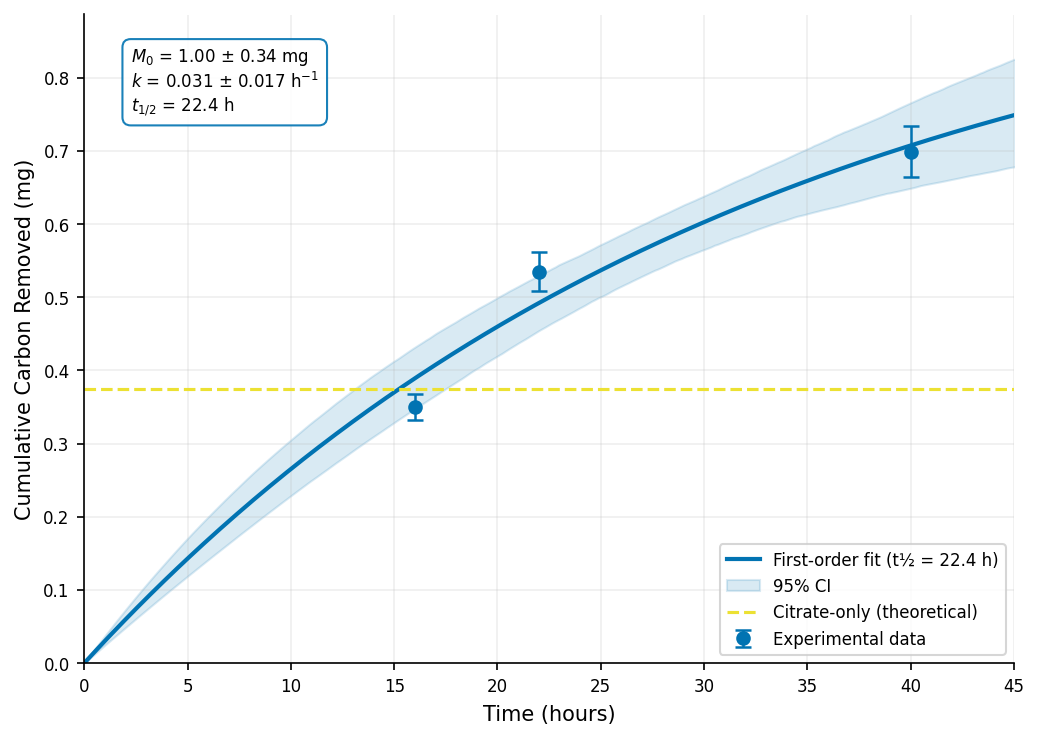


KEY FINDINGS

✓ First-order kinetics fit with t1/2 = 22.4 h
✓ Total carbon removed (0.699 mg) vs citrate-only baseline (0.375 mg)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrow
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import savgol_filter
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set Nature-quality publication defaults
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.figsize': (14, 10),
    'font.size': 9,
    'font.family': 'sans-serif',
    'axes.linewidth': 0.8,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'axes.labelweight': 'normal',
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'lines.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,  # We'll add selectively
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
})

# Nature-style colorblind-friendly palette
COLORS = {
    'dialysis': '#0173B2',      # Strong blue
    'centrifuge': '#DE8F05',    # Orange
    'neutral': '#949494',       # Gray
    'good': '#56B4E9',          # Light blue
    'bad': '#CC78BC',           # Light purple
    'citrate': '#ECE133',       # Yellow
    'water': '#A0A0A0',         # Light gray
}

def load_dialysis_doc_data():
    """Load dialysis DOC measurement data as in dialysis_plots.py."""
    # Data from the dialysis_plots.py file
    V_inside_mL = 10.0
    CITRATE_ONLY_M0_mg = 0.375  # 1.0 mg citrate × 0.375 C fraction

    data = [
        {"run": 1, "t_hr": 16.0, "C_meas_mg_per_L": 1.04, "C_adj_mg_per_L": 35.0},
        {"run": 2, "t_hr": 22.0, "C_meas_mg_per_L": 0.58, "C_adj_mg_per_L": 18.5},
        {"run": 3, "t_hr": 40.0, "C_meas_mg_per_L": 0.52, "C_adj_mg_per_L": 16.4},
    ]

    df = pd.DataFrame(data)

    # Back-calculate bath volumes
    df["V_bath_mL"] = (df["C_adj_mg_per_L"] / df["C_meas_mg_per_L"]) * V_inside_mL
    df["V_bath_L"] = df["V_bath_mL"] / 1000.0

    # Calculate masses
    df["mass_mg"] = df["C_meas_mg_per_L"] * df["V_bath_L"]
    df = df.sort_values("t_hr").reset_index(drop=True)
    df["mass_cum_mg"] = df["mass_mg"].cumsum()

    return df, V_inside_mL, CITRATE_ONLY_M0_mg

def fit_dialysis_kinetics(df):
    """Fit first-order kinetics model to dialysis data."""

    def M_cum_model(t, M0_hat, k):
        return M0_hat * (1.0 - np.exp(-k * t))

    t = df["t_hr"].to_numpy()
    y = df["mass_cum_mg"].to_numpy()

    # Add t=0 point
    t = np.concatenate([[0], t])
    y = np.concatenate([[0], y])

    # Fit the model
    popt, pcov = curve_fit(M_cum_model, t[1:], y[1:],
                          p0=[y[-1]*1.2, 0.03], maxfev=20000)
    M0_hat, k_hat = popt

    # Calculate uncertainties
    perr = np.sqrt(np.diag(pcov))

    # Bootstrap for confidence intervals
    n_bootstrap = 2000
    np.random.seed(42)
    bootstrap_params = []

    for _ in range(n_bootstrap):
        # Resample data with noise
        noise = np.random.normal(0, 0.03, len(y[1:]))
        y_boot = y[1:] + noise
        y_boot = np.clip(y_boot, 0, None)

        try:
            popt_boot, _ = curve_fit(M_cum_model, t[1:], y_boot,
                                    p0=[M0_hat, k_hat], maxfev=1000)
            bootstrap_params.append(popt_boot)
        except:
            continue

    # Generate smooth curves with CI
    t_smooth = np.linspace(0, 48, 300)
    y_fit = M_cum_model(t_smooth, M0_hat, k_hat)

    # Calculate CI from bootstrap
    if bootstrap_params:
        bootstrap_curves = [M_cum_model(t_smooth, *params) for params in bootstrap_params]
        ci_lower = np.percentile(bootstrap_curves, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_curves, 97.5, axis=0)
    else:
        ci_lower = y_fit * 0.9
        ci_upper = y_fit * 1.1

    # Calculate derived parameters
    t_half = np.log(2) / k_hat if k_hat > 0 else np.inf

    # Calculate fraction of theoretical maximum (for secondary axis)
    frac_max = y_fit / M0_hat

    return {
        't_data': t,
        'y_data': y,
        't_smooth': t_smooth,
        'y_fit': y_fit,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'frac_max': frac_max,
        'M0': M0_hat,
        'k': k_hat,
        't_half': t_half,
        'M0_err': perr[0],
        'k_err': perr[1]
    }

# The following functions are kept unchanged but will not be used for the single-plot output.
def create_waterfall_plot(ax, df, comparisons):
    pass

def calculate_improved_metrics(df, col_name):
    return {}

def create_spider_plot(ax, dialysis_metrics, centrifuge_metrics, stats_results):
    pass

def create_molecular_schematic(ax):
    pass

def create_figure_2_improved(df_spec, comparisons, kinetics_data, doc_df):
    pass

def perform_statistical_comparison(dialysis_metrics, centrifuge_metrics):
    return {}

def create_table_2(stats_results, doc_df):
    return pd.DataFrame([])

def main():
    """Main execution function that now produces only the first plot."""
    print("=" * 70)
    print("Act II: The Commercial Compromise - Panel A Only")
    print("Kinetics figure only. No external CSV loads.")
    print("=" * 70)

    # Create output directory
    output_dir = Path('figures/act2_v2')
    output_dir.mkdir(parents=True, exist_ok=True)

    # Load DOC data from dialysis
    print("\nLoading dialysis DOC data...")
    doc_df, V_inside_mL, CITRATE_ONLY_M0_mg = load_dialysis_doc_data()
    print(f"  Loaded {len(doc_df)} time points")
    print(f"  Total carbon removed: {doc_df['mass_cum_mg'].iloc[-1]:.3f} mg")

    # Fit kinetics model
    print("\nFitting dialysis kinetics...")
    kinetics_data = fit_dialysis_kinetics(doc_df)
    print(f"  M0 = {kinetics_data['M0']:.3f} ± {kinetics_data['M0_err']:.3f} mg")
    print(f"  k = {kinetics_data['k']:.3f} ± {kinetics_data['k_err']:.3f} h^-1")
    print(f"  t1/2 = {kinetics_data['t_half']:.1f} hours")

    # Create single-panel figure (Panel A only)
    fig, ax1 = plt.subplots(figsize=(7, 5))

    # Plot experimental points
    ax1.errorbar(kinetics_data['t_data'][1:], kinetics_data['y_data'][1:],
                 yerr=kinetics_data['y_data'][1:]*0.05,  # 5% error bars
                 fmt='o', color=COLORS['dialysis'], markersize=6,
                 capsize=4, capthick=1.2, label='Experimental data')

    # Plot fitted curve
    ax1.plot(kinetics_data['t_smooth'], kinetics_data['y_fit'],
             color=COLORS['dialysis'], linewidth=2,
             label=f"First-order fit (t½ = {kinetics_data['t_half']:.1f} h)")

    # Add confidence bands
    ax1.fill_between(kinetics_data['t_smooth'],
                     kinetics_data['ci_lower'],
                     kinetics_data['ci_upper'],
                     color=COLORS['dialysis'], alpha=0.15,
                     label='95% CI')

    # Mark citrate-only baseline
    citrate_only = 0.375  # mg C from 1 mg citrate
    ax1.axhline(citrate_only, color=COLORS['citrate'], linestyle='--',
                linewidth=1.5, label='Citrate-only (theoretical)')

    # Labels and styling
    ax1.set_xlabel('Time (hours)', fontsize=10)
    ax1.set_ylabel('Cumulative Carbon Removed (mg)', fontsize=10)
    ax1.grid(True, alpha=0.2)
    ax1.set_xlim(0, 45)
    ax1.set_ylim(0, max(kinetics_data['y_fit']) * 1.15)

    # Legend
    ax1.legend(loc='lower right', frameon=True, fancybox=True, shadow=False)

    # Kinetic parameters inset
    textstr = f'$M_0$ = {kinetics_data["M0"]:.2f} ± {kinetics_data["M0_err"]:.2f} mg\n'
    textstr += f'$k$ = {kinetics_data["k"]:.3f} ± {kinetics_data["k_err"]:.3f} h$^{{-1}}$\n'
    textstr += f'$t_{{1/2}}$ = {kinetics_data["t_half"]:.1f} h'
    props = dict(boxstyle='round,pad=0.5', facecolor='white',
                 edgecolor=COLORS['dialysis'], alpha=0.9)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=8,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 70)
    print("KEY FINDINGS")
    print("=" * 70)
    print(f"\n✓ First-order kinetics fit with t1/2 = {kinetics_data['t_half']:.1f} h")
    print(f"✓ Total carbon removed ({doc_df['mass_cum_mg'].iloc[-1]:.3f} mg) vs citrate-only baseline ({CITRATE_ONLY_M0_mg} mg)")

    plt.close('all')

if __name__ == "__main__":
    main()

ACT II: REDSHIFT ANALYSIS ONLY

CSV loaded:
  Path: /content/drive/MyDrive/RegeneronSTS/data/UVScans_CleanedAbsorbance.csv
  Shape: (602, 9)
  Columns: ['Wavelength', '0.115MB_AuNP_MQW', '0.115MB_cenAuNP_MQW', '0.30MB_AuNP_MQW', '0.30MB_cenAuNP_MQW', '0.115MB_AuNP_As30', '0.115MB_cenAuNP_As30', '0.30MB_AuNP_As30_1', '0.30MB_cenAuNP_As30'] 

Head:
 Wavelength  0.115MB_AuNP_MQW  0.115MB_cenAuNP_MQW  0.30MB_AuNP_MQW  0.30MB_cenAuNP_MQW  0.115MB_AuNP_As30  0.115MB_cenAuNP_As30  0.30MB_AuNP_As30_1  0.30MB_cenAuNP_As30
      200.0           0.37239              0.29498          0.26086             0.28961            0.36463               0.30958             0.26196              0.18362
      201.0           0.35596              0.28816          0.24227             0.27381            0.34986               0.30218             0.24929              0.17868
      202.0           0.34378              0.28129          0.22597             0.25945            0.33858               0.29557             

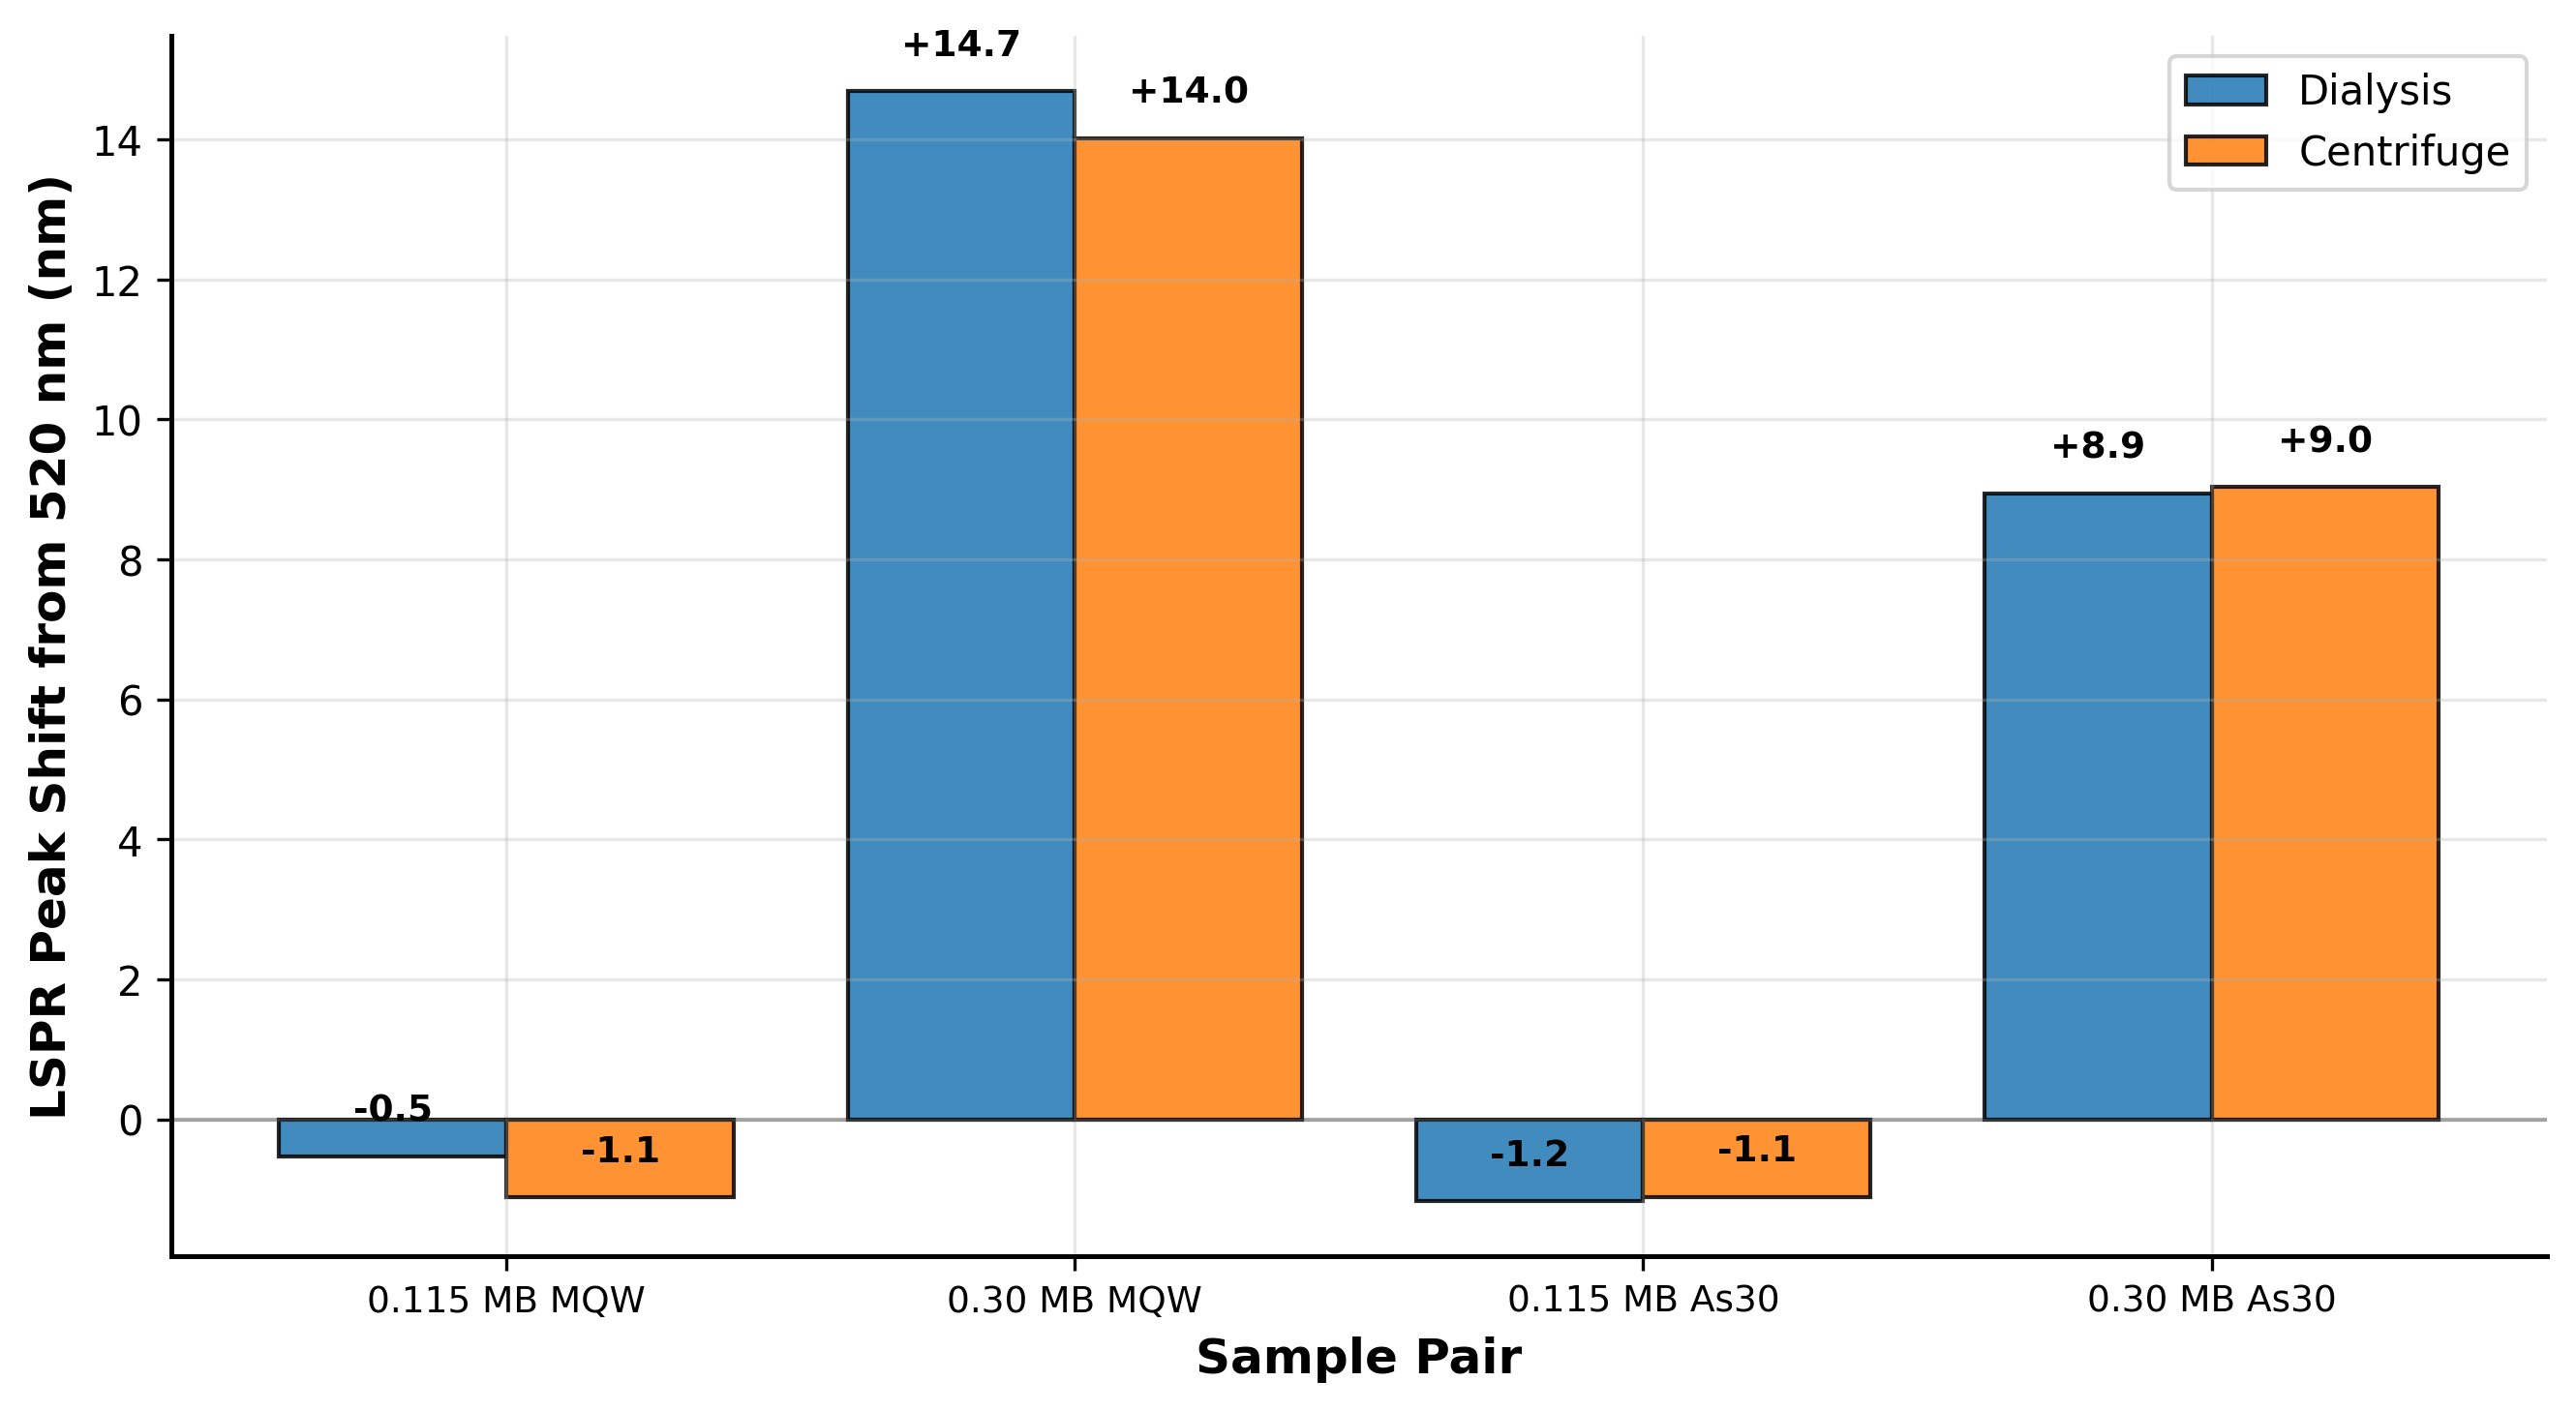


Summary:
  Mean dialysis redshift: +5.48 nm
  Mean centrifuge redshift: +5.21 nm


In [ ]:
#!/usr/bin/env python3
"""
Act II: Redshift Analysis Only
Loads spectra CSV, prints a quick preview, and plots method-induced LSPR shifts.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.family': 'Arial',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 2.0,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8,
})

COLORS = {
    'dialysis': '#1f77b4',
    'centrifuge': '#ff7f0e',
    'background': '#f8f9fa',
}

print("="*80)
print("ACT II: REDSHIFT ANALYSIS ONLY")
print("="*80)

# ---------------------------------------------------------------------
# Load and display CSV
# ---------------------------------------------------------------------
csv_path = '/content/drive/MyDrive/RegeneronSTS/data/UVScans_CleanedAbsorbance.csv'
df_spectra = pd.read_csv(csv_path)

print("\nCSV loaded:")
print(f"  Path: {csv_path}")
print(f"  Shape: {df_spectra.shape}")
print("  Columns:", list(df_spectra.columns)[:10], "..." if len(df_spectra.columns) > 10 else "")
print("\nHead:")
print(df_spectra.head().to_string(index=False))

# ---------------------------------------------------------------------
# Redshift computation
# ---------------------------------------------------------------------
pairs = [
    ('0.115MB_AuNP_MQW',     '0.115MB_cenAuNP_MQW', '0.115 MB MQW'),
    ('0.30MB_AuNP_MQW',      '0.30MB_cenAuNP_MQW',  '0.30 MB MQW'),
    ('0.115MB_AuNP_As30',    '0.115MB_cenAuNP_As30','0.115 MB As30'),
    ('0.30MB_AuNP_As30_1',   '0.30MB_cenAuNP_As30', '0.30 MB As30'),
]

wavelengths = df_spectra['Wavelength'].values

def find_peak_position_precise(spectrum, wavelengths, search_range=(510, 540)):
    mask = (wavelengths >= search_range[0]) & (wavelengths <= search_range[1])
    if not np.any(mask):
        return np.nan
    wl = wavelengths[mask]
    ab = spectrum[mask]
    i = np.argmax(ab)
    if 1 <= i <= len(ab) - 2:
        y1, y2, y3 = ab[i-1:i+2]
        x1, x2, x3 = wl[i-1:i+2]
        denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
        if abs(denom) > 1e-12:
            a = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
            b = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
            if abs(a) > 1e-12:
                x_peak = -b / (2*a)
                if search_range[0] <= x_peak <= search_range[1]:
                    return x_peak
    return wl[i]

baseline_peak = 520.0

rows = []
for dial_col, cent_col, label in pairs:
    if dial_col not in df_spectra.columns or cent_col not in df_spectra.columns:
        print(f"  Skipping {label} due to missing columns.")
        continue
    dial = df_spectra[dial_col].values
    cent = df_spectra[cent_col].values
    peak_dial = find_peak_position_precise(dial, wavelengths)
    peak_cent = find_peak_position_precise(cent, wavelengths)
    rows.append({
        'sample': label,
        'redshift_dialysis': peak_dial - baseline_peak,
        'redshift_centrifuge': peak_cent - baseline_peak
    })
    print(f"  {label}: Dialysis {peak_dial:.2f} nm, Centrifuge {peak_cent:.2f} nm")

redshift_df = pd.DataFrame(rows)
if redshift_df.empty:
    raise RuntimeError("No valid sample pairs found in the CSV.")

# ---------------------------------------------------------------------
# Plot: Method-induced spectral shifts (single subplot)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(redshift_df))
w = 0.4

bars1 = ax.bar(x - w/2, redshift_df['redshift_dialysis'], width=w,
               label='Dialysis', color=COLORS['dialysis'],
               alpha=0.85, edgecolor='black', linewidth=1)
bars2 = ax.bar(x + w/2, redshift_df['redshift_centrifuge'], width=w,
               label='Centrifuge', color=COLORS['centrifuge'],
               alpha=0.85, edgecolor='black', linewidth=1)

for b in list(bars1) + list(bars2):
    h = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, h + 0.4, f'{h:+.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.axhline(0, color='black', linewidth=1, alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels([s.replace(' ', ' ') for s in redshift_df['sample']], fontsize=9)
ax.set_xlabel('Sample Pair', fontweight='bold')
ax.set_ylabel('LSPR Peak Shift from 520 nm (nm)', fontweight='bold')
ax.legend(frameon=True, fancybox=True)



plt.tight_layout()
plt.show()

# Summary
mean_dial = np.mean(redshift_df['redshift_dialysis'])
mean_cent = np.mean(redshift_df['redshift_centrifuge'])

print("\nSummary:")
print(f"  Mean dialysis redshift: {mean_dial:+.2f} nm")
print(f"  Mean centrifuge redshift: {mean_cent:+.2f} nm")


#Coarse Pass Justification


ΔA values at key wavelengths:

0.1MB:
  λ1 (522 nm): 0.0047
  λ2 (620 nm): 0.0077
  λ3 (670 nm): 0.0020

0.3MB:
  λ1 (522 nm): 0.0034
  λ2 (620 nm): 0.0330
  λ3 (670 nm): 0.0172

0.6MB:
  λ1 (522 nm): 0.0130
  λ2 (620 nm): 0.0268
  λ3 (670 nm): 0.0239

0.9MB:
  λ1 (522 nm): 0.0154
  λ2 (620 nm): 0.0156
  λ3 (670 nm): 0.0114


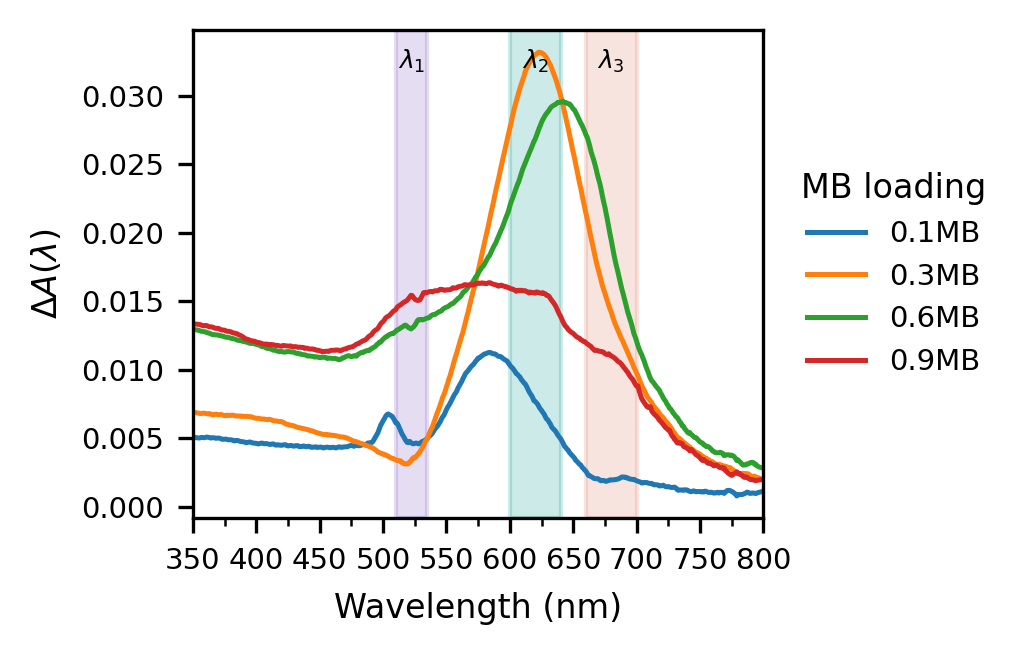

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path

# ===== Inputs =====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250725_UVScans.csv"
OUT_DIR  = "/content/drive/MyDrive/RegeneronSTS/figures"

PATHLENGTH_CM = 1.0
k_by_loading = {"0.1MB": 1.0, "0.3MB": 1.0, "0.6MB": 1.0, "0.9MB": 1.0}

GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
USE_SMOOTH = True
SG_WINDOW, SG_POLY = 11, 2

# Bands
LSPR_BAND = (510, 535)
AGG_BAND  = (600, 640)
MB_BAND   = (660, 700)

# ===== Load and prep =====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
wl_src = df["Wavelength"].to_numpy()

tags = ["0.1MB", "0.3MB", "0.6MB", "0.9MB"]
pairs = [(t, f"{t}_AuNP", f"{t}_AuNP_As")
         for t in tags if f"{t}_AuNP" in df.columns and f"{t}_AuNP_As" in df.columns]

grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)

def interp_to_grid(x, y, xg):
    return np.interp(xg, x, y)

def normalize_pathlength(A, l_cm):
    return A if l_cm == 1.0 else A * (1.0 / l_cm)

curves = []
for tag, bcol, acol in pairs:
    k = float(k_by_loading[tag])
    A_blank = pd.to_numeric(df[bcol], errors="coerce").to_numpy()
    A_as    = pd.to_numeric(df[acol], errors="coerce").to_numpy()

    A_blank = normalize_pathlength(A_blank, PATHLENGTH_CM)
    A_as    = normalize_pathlength(A_as,    PATHLENGTH_CM)

    A_blank_g = interp_to_grid(wl_src, A_blank, grid)
    A_as_g    = interp_to_grid(wl_src, A_as,    grid)

    dA = A_as_g - k * A_blank_g
    if USE_SMOOTH and len(dA) >= SG_WINDOW:
        dA = savgol_filter(dA, SG_WINDOW, SG_POLY, mode="interp")

    curves.append((tag, dA))

# === Report ΔA at λ1, λ2, λ3 ===
lambda_points = {"λ1 (522 nm)": 522, "λ2 (620 nm)": 620, "λ3 (670 nm)": 670}
print("\nΔA values at key wavelengths:")
for tag, dA in curves:
    print(f"\n{tag}:")
    for name, lam in lambda_points.items():
        idx = np.argmin(np.abs(grid - lam))  # nearest wavelength index
        print(f"  {name}: {dA[idx]:.4f}")

dA_all = np.vstack([c[1] for c in curves])
ymin, ymax = float(np.nanmin(dA_all)), float(np.nanmax(dA_all))
pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)

# ===== Plot =====
inch = 1/25.4
fig, ax = plt.subplots(figsize=(90*inch, 58*inch), dpi=300)

# Shaded regions
ax.axvspan(*LSPR_BAND, color="#7E57C2", alpha=0.2)
ax.axvspan(*AGG_BAND,  color="#009688", alpha=0.2)
ax.axvspan(*MB_BAND,   color="#E07A5F", alpha=0.2)

'''
band_specs = [
    ("Band I (λ$_1$)  LSPR",  LSPR_BAND, "#7E57C2"),  # purple
    ("Band II (λ$_2$) Agg.",  AGG_BAND,  "#009688"),  # teal
    ("Band III (λ$_3$) MB Q", MB_BAND,   "#E07A5F"),  # terracotta
]
'''

# Label shaded bands with lambda notation
for band, label in zip([LSPR_BAND, AGG_BAND, MB_BAND],
                       [r"$\lambda_1$", r"$\lambda_2$", r"$\lambda_3$"]):
    xpos = np.mean(band)
    ypos = ymax * 0.95  # 5% above max signal
    ax.text(xpos, ypos, label,
            ha="center", va="bottom",
            fontsize=6, fontweight="bold", color="black")

# Curves
colors = {"0.1MB": "C0", "0.3MB": "C1", "0.6MB": "C2", "0.9MB": "C3"}
for tag, dA in curves:
    lw = 1.2
    ax.plot(grid, dA, label=tag, color=colors[tag], lw=lw)

# Axes setup
ax.set_xlim(GRID_MIN, GRID_MAX)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xticks(np.arange(350, 801, 50))
ax.set_xticks(np.arange(350, 801, 25), minor=True)
ax.set_xlabel("Wavelength (nm)", fontsize=8)
ax.set_ylabel(r"$\Delta A(\lambda)$", fontsize=8)

ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=0)

# Legend and title
ax.legend(title="MB loading", frameon=False, loc="center left",
          bbox_to_anchor=(1.02, 0.5), fontsize=7, title_fontsize=8)


fig.tight_layout()
plt.show()

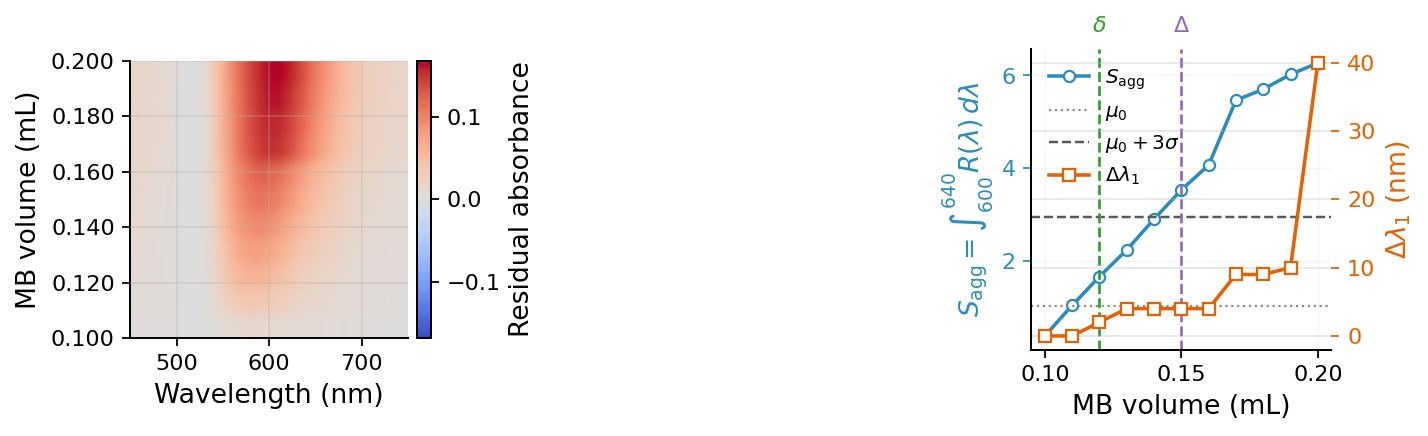

In [ ]:
# ==== Imports ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Inputs ====
CSV_PATH = "/content/drive/MyDrive/RegeneronSTS/data/20250728_UVScans.csv"

GRID_MIN, GRID_MAX, GRID_STEP = 350, 800, 1
HEATMAP_XLIM = (450, 750)

LSPR_NORM_WIN = (520, 525)   # normalization window
LSPR_PEAK_WIN = (500, 560)   # λ1 search
AGG_WIN       = (600, 640)   # S_agg integration band

DLAM_THRESHOLD_NM = 1.0
LOW_MB_RANGE = (0.10, 0.12)

# ==== Load ====
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]
assert "Wavelength" in df.columns, "CSV must include a 'Wavelength' column."
df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
wl_src = df["Wavelength"].to_numpy()

# Reference spectrum
ref_col = None
for cand in ["AuNP", "AuNP_Blank", "AuNP_Dialyzed"]:
    if cand in df.columns:
        ref_col = cand
        break
assert ref_col is not None, "No AuNP reference column found."
A_ref = pd.to_numeric(df[ref_col], errors="coerce").to_numpy()

# MB blank columns like "0.11MB_AuNP"
blank_cols = [c for c in df.columns if c.endswith("_AuNP") and c != ref_col]

def parse_mb(colname):
    m = re.search(r"([\d.]+)\s*MB", colname, flags=re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

mb_vals = np.array([parse_mb(c) for c in blank_cols], dtype=float)
mask = ~np.isnan(mb_vals)
blank_cols = [c for c,k in zip(blank_cols, mask) if k]
mb_vals = mb_vals[mask]

# Helpers
grid = np.arange(GRID_MIN, GRID_MAX + 1, GRID_STEP)
interp = lambda x,y,xg: np.interp(xg, x, y)

def band_mean(wl, y, band):
    m = (wl >= band[0]) & (wl <= band[1])
    return np.nanmean(y[m]) if np.any(m) else np.nan

def band_area(wl, y, band):
    m = (wl >= band[0]) & (wl <= band[1])
    return np.trapezoid(y[m], wl[m]) if np.any(m) else np.nan

# Reference on grid
A_ref_g = interp(wl_src, A_ref, grid)
ref_norm = band_mean(grid, A_ref_g, LSPR_NORM_WIN)

# λ1,ref
m_pk_ref = (grid >= LSPR_PEAK_WIN[0]) & (grid <= LSPR_PEAK_WIN[1])
lam_ref = grid[m_pk_ref][np.nanargmax(A_ref_g[m_pk_ref])]

# Build metrics and residual map rows
records = []
residual_rows = []   # list of (MB, residual_on_grid)

for col, v in sorted(zip(blank_cols, mb_vals), key=lambda t: t[1]):
    A = pd.to_numeric(df[col], errors="coerce").to_numpy()
    A_g = interp(wl_src, A, grid)
    # normalize at 520–525
    blank_norm = band_mean(grid, A_g, LSPR_NORM_WIN)
    scale = ref_norm / blank_norm if np.isfinite(blank_norm) and blank_norm != 0 else 1.0
    A_norm = A_g * scale

    R = A_norm - A_ref_g
    residual_rows.append((v, R))

    S_agg = band_area(grid, R, AGG_WIN)
    m_pk = (grid >= LSPR_PEAK_WIN[0]) & (grid <= LSPR_PEAK_WIN[1])
    lam_blank = grid[m_pk][np.nanargmax(A_norm[m_pk])]
    dlam = lam_blank - lam_ref

    records.append({"MB": v, "S_agg": S_agg, "dlam": dlam})

metrics = pd.DataFrame.from_records(records).sort_values("MB").reset_index(drop=True)

# μ0, σ0, thresholds
m_low = (metrics["MB"] >= LOW_MB_RANGE[0]) & (metrics["MB"] <= LOW_MB_RANGE[1])
mu0  = float(metrics.loc[m_low, "S_agg"].mean())
sig0 = float(metrics.loc[m_low, "S_agg"].std(ddof=1)) if m_low.sum() >= 2 else 0.0
thr_S = mu0 + 3*sig0

# First crossings
def first_crossing(x, y, thr):
    for xi, yi in zip(x, y):
        if np.isfinite(yi) and yi >= thr:
            return xi
    return None

MBs = metrics["MB"].values
mb_min = first_crossing(MBs, metrics["dlam"].values, DLAM_THRESHOLD_NM)   # lower bound from Δλ1 rule
mb_max = first_crossing(MBs, metrics["S_agg"].values, thr_S)              # upper bound from S_agg rule

# ==== Plot: two square panels side-by-side ====
plt.rcParams.update({
    "figure.dpi": 160,
    "font.size": 9,
    "axes.linewidth": 0.9,
})

fig, (axA, axB_left) = plt.subplots(1, 2, figsize=(9, 4.5))
axB_right = axB_left.twinx()

# ---------- A: Residual heatmap (fixed scaling) ----------
residual_rows.sort(key=lambda t: t[0])
mb_sorted = np.array([v for v,_ in residual_rows])
residual_map = np.vstack([r for _,r in residual_rows])

xmask = (grid >= HEATMAP_XLIM[0]) & (grid <= HEATMAP_XLIM[1])
wl_view = grid[xmask]
res_view = residual_map[:, xmask]

vmax = np.nanmax(np.abs(res_view))
vmax = vmax if np.isfinite(vmax) and vmax > 0 else 1e-3

im = axA.imshow(
    res_view,
    extent=[wl_view.min(), wl_view.max(), mb_sorted.min(), mb_sorted.max()],
    origin="lower",
    cmap="coolwarm",
    vmin=-vmax, vmax=vmax,
    aspect="auto"             # <- fix
)

axA.set_xlim(HEATMAP_XLIM)
axA.set_ylim(mb_sorted.min(), mb_sorted.max())   # <- lock y-lims

# clean 0.10–0.20 ticks
yticks = np.round(np.linspace(mb_sorted.min(), mb_sorted.max(), 6), 3)
axA.set_yticks(yticks)
axA.set_yticklabels([f"{t:.3f}" for t in yticks])

axA.set_xlabel("Wavelength (nm)")
axA.set_ylabel("MB volume (mL)")
cbar = fig.colorbar(im, ax=axA, fraction=0.046, pad=0.03)
cbar.set_label("Residual absorbance")
axA.set_box_aspect(1)

# remove any set_box_aspect(1) you had here
# ---------- B: Combined S_agg and Δλ1 (minimal) ----------
x = MBs
y_S = metrics["S_agg"].values
y_D = metrics["dlam"].values

# Left: S_agg with μ0 and μ0+3σ
axB_left.plot(x, y_S, marker="o", ms=5, mfc="white", mec="#2b8cbe",
              lw=1.6, color="#2b8cbe", label=r"$S_{\mathrm{agg}}$")
axB_left.axhline(mu0,  color="0.55", lw=1.0, ls=":",  label=r"$\mu_0$")
axB_left.axhline(thr_S, color="0.35", lw=1.1, ls="--", label=r"$\mu_0+3\sigma$")
axB_left.set_xlabel("MB volume (mL)")
axB_left.set_ylabel(r"$S_{\mathrm{agg}}=\int_{600}^{640} R(\lambda)\,d\lambda$")
axB_left.yaxis.set_label_coords(-0.12, 0.5)  # shift label left
axB_left.set_box_aspect(1)
axB_left.grid(True, alpha=0.12, linewidth=0.6)

# Make left axis blue
axB_left.tick_params(axis="y", colors="#2b8cbe")
axB_left.yaxis.label.set_color("#2b8cbe")
axB_left.spines["left"].set_color("#2b8cbe")

# Right: Δλ1 (no horizontal 1 nm line)
axB_right.plot(x, y_D, marker="s", ms=5, mfc="white", mec="#e66101",
               lw=1.6, color="#e66101", label=r"$\Delta\lambda_1$")
axB_right.set_ylabel(r"$\Delta\lambda_1$ (nm)")


# Make right axis orange
axB_right.tick_params(axis="y", colors="#e66101")
axB_right.yaxis.label.set_color("#e66101")
axB_right.spines["right"].set_color("#e66101")

# Two vertical bounds only, with concise labels (δ = first detectable drift, Δ = significant drift)
y_top = axB_left.get_ylim()[1]
if mb_min is not None:
    axB_left.axvline(mb_min, color="#2ca02c", lw=1.2, ls="--")
    axB_left.annotate(r"$\delta$", xy=(mb_min, y_top),
                      xytext=(0, 6), textcoords="offset points",
                      ha="center", va="bottom",
                      fontsize=10, color="#2ca02c",
                      bbox=dict(facecolor="white", edgecolor="none", pad=0.6, alpha=0.85))
if mb_max is not None:
    axB_left.axvline(mb_max, color="#9467bd", lw=1.2, ls="--")
    axB_left.annotate(r"$\Delta$", xy=(mb_max, y_top),
                      xytext=(0, 6), textcoords="offset points",
                      ha="center", va="bottom",
                      fontsize=10, color="#9467bd",
                      bbox=dict(facecolor="white", edgecolor="none", pad=0.6, alpha=0.85))

# Merge legends
hL, lL = axB_left.get_legend_handles_labels()
hR, lR = axB_right.get_legend_handles_labels()
axB_left.legend(hL + hR, lL + lR, frameon=False, fontsize=9, loc="upper left")

plt.tight_layout()
plt.subplots_adjust(wspace=2)  # increase spacing between A and B
plt.show()